In [159]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/content/drive/MyDrive') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

%ls /content/drive/MyDrive

'Colab Notebooks'/                       Medical_insurance.csv
 Constraint_Programming_Jan_Poreba.pdf   sentimentdataset_corrputed_2.csv
'DANE LEKCJA 1'@                         sentimentdataset_corrputed.csv
'Kopia EDA_zadanie.ipynb'                sentimentdataset.csv
 Medical_insurance_corrputed.csv         titanic.csv


# Analiza i przetwarzanie danych na temat Titanica

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.

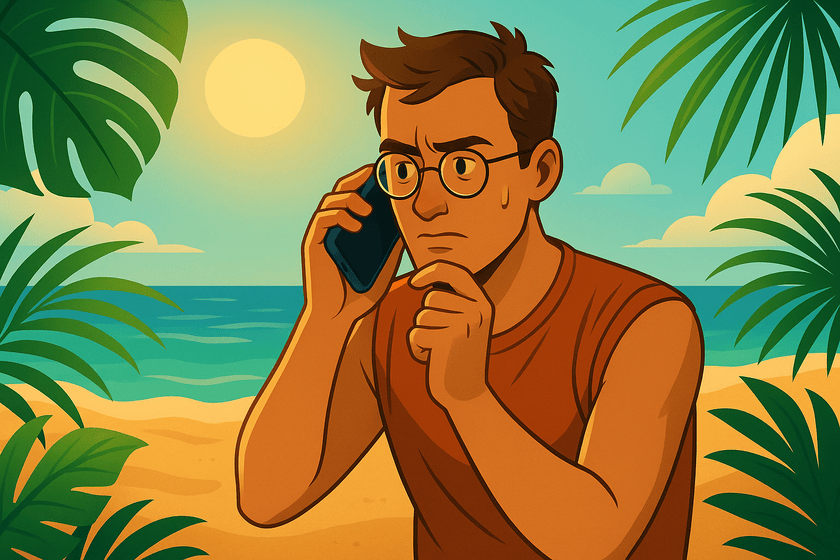

(*AI-generated image*)


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


In [161]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [162]:
titanic_df.dtypes

,0
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object


Typy danych są odpowiednie do wykonania analizy.

In [163]:
def get_percentage_missing(df, axis):
  """
    Zwraca procent brakujących wartości (NaN) w wierszach lub kolumnach DataFrame.

    df : pandas.DataFrame
        Tabela danych, dla której liczone są braki.

    axis : int
        Oś, względem której obliczane są braki:
        - 0 : procent braków w każdej kolumnie
        - 1 : procent braków w każdym wierszu
  """
  missing_rows = df.isna().sum(axis=axis)
  missing_rows_perc = np.round(missing_rows / df.shape[axis] * 100, 2)
  return missing_rows_perc[missing_rows_perc > 0]

In [164]:
missing_cols_mi = get_percentage_missing(titanic_df, axis=0)
missing_cols_mi

,0
Age,19.87
Fare,11.00
Cabin,77.10
Embarked,0.22


In [165]:
titanic_df['Age'] = titanic_df['Age'].fillna(-1.0);
# print(titanic_df.head)

W przypadku brakującego wieku wstawiam -1.

In [166]:
titanic_df['Fare'] = titanic_df['Fare'].fillna(titanic_df['Fare'].median())
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('U');

Brakującą cenę biletu uzupełniam medianą, a Embarked oraz Cabin oznaczam jako 'Unknown' - 'U'

In [167]:
titanic_df['IsAlone'] = (titanic_df['SibSp'] + titanic_df['Parch'] > 0).astype(int)
titanic_df['CabinKnown'] = (~titanic_df['Cabin'].isnull()).astype(int)
titanic_df['CabinDeck'] = titanic_df['Cabin'].fillna('U').astype(str).str[0]


# print(titanic_df.head)
# print(titanic_df['Embarked'])



Dodatkowe cehcy: IsAlone - inf. czy ktoś z rodziny pasażera jest na pokładzie, CabinKnown - flaga inf. o tym czy pasażer miał przypisaną kabinę oraz CabinDeck - kod pokładu, na którym znajdowała się kabina

# Wartości skrajne

In [168]:
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Sex', 'Pclass', 'Embarked', 'IsAlone', 'CabinKnown']

def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_bound = Q1 - 1.5 * IQR
    high_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < low_bound) | (df[col] > high_bound)]
    return outliers


def lower_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_bound = Q1 - 1.5 * IQR
    high_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < low_bound)]
    return outliers


def upper_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_bound = Q1 - 1.5 * IQR
    high_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] > high_bound)]
    return outliers

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot(df, column_name):
    """
    Displays a boxplot of the choosen column to show its distribution.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    Returns:
        None. Displays the bar chart.
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column_name].dropna(), color='lightgreen') # as you can see, you can use sns and plt at the same time
    plt.title(f'Distribution of {column_name} (boxplot)')
    plt.xlabel(column_name)

    plt.show()

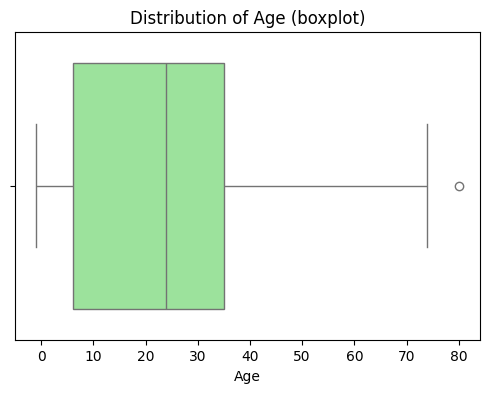

Znaleziono 0 wartości odstających od dołu dla cechy Age.
Znaleziono 1 wartości odstających od góry dla cechy Age.


In [170]:
boxplot(titanic_df, 'Age')
l_outliers  = lower_outliers(titanic_df, 'Age')
print(f"Znaleziono {len(l_outliers)} wartości odstających od dołu dla cechy Age.")
u_outliers  = upper_outliers(titanic_df, 'Age')
print(f"Znaleziono {len(u_outliers)} wartości odstających od góry dla cechy Age.")

Powyższy boxplot BMI pokazuje, że większość danych mieści się w typowym przedziale wartości, występuje jendna wartość odstająca od góry - wiek 80 lat.
Mediana znajduje się bliżej trzeciego niż pierwszego kwartylu, co oznacza że mamy do czynienia z rozkładem skośnym.

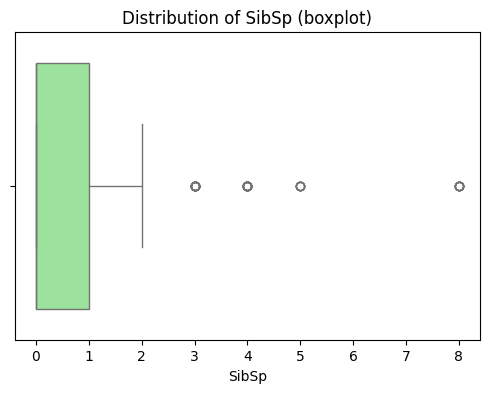

Znaleziono 0 wartości odstających od dołu dla cechy SibSp.
Znaleziono 46 wartości odstających od góry dla cechy SibSp.


In [171]:
boxplot(titanic_df, 'SibSp')
l_outliers  = lower_outliers(titanic_df, 'SibSp')
print(f"Znaleziono {len(l_outliers)} wartości odstających od dołu dla cechy SibSp.")
u_outliers  = upper_outliers(titanic_df, 'SibSp')
print(f"Znaleziono {len(u_outliers)} wartości odstających od góry dla cechy SibSp.")

Powyższy wykres pokazuje, że wsytępuje dużo wartości odstający od góry. Mamy do czynienia z rozkładem skośnym - mediana jest równa miniamalnej wartości.

In [172]:
def plot_numeric_histogram(df, column_name):
    """
    Plots a histogram for the specified column in the DataFrame,
    and adds vertical lines for the mean and median.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
    Returns:
        None. Displays the histogram.
    """

    data = df[column_name].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, color='steelblue', edgecolor='black')
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [173]:
def plot_categorical_column(df, column_name):
    """
    Plots a bar chart for the specified categorical column.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    Returns:
        None. Displays the bar chart.
    """

    # count occurrences of each category
    counts = df[column_name].value_counts()

    plt.figure(figsize=(6, 4))
    counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

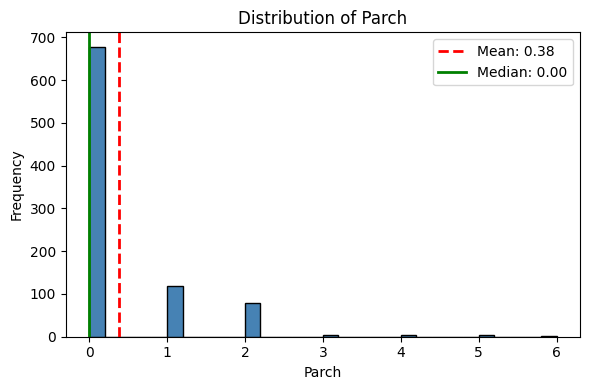

Znaleziono 0 wartości odstających od dołu dla cechy Parch.
Znaleziono 213 wartości odstających od góry dla cechy Parch.


In [174]:


plot_numeric_histogram(titanic_df, 'Parch')
l_outliers  = lower_outliers(titanic_df, 'Parch')
print(f"Znaleziono {len(l_outliers)} wartości odstających od dołu dla cechy Parch.")
u_outliers  = upper_outliers(titanic_df, 'Parch')
print(f"Znaleziono {len(u_outliers)} wartości odstających od góry dla cechy Parch.")

Widzimy na powyzszym wykresie, że większość pasażerów nie brała ze sobą dzieci i rodziców na pokłądzie - pasażerowie, którzy wybrali się z rodzicem lub dzieckiem są wartościami odstającymi - jest ich sporo (powyżej 200).

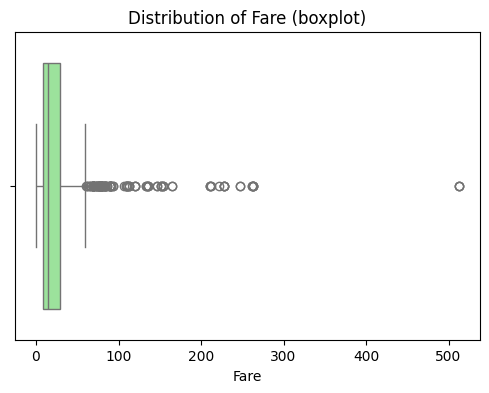

Znaleziono 0 wartości odstających od dołu dla cechy Fare.
Znaleziono 110 wartości odstających od góry dla cechy Fare.


In [175]:
boxplot(titanic_df, 'Fare')
l_outliers  = lower_outliers(titanic_df, 'Fare')
print(f"Znaleziono {len(l_outliers)} wartości odstających od dołu dla cechy Fare.")
u_outliers  = upper_outliers(titanic_df, 'Fare')
print(f"Znaleziono {len(u_outliers)} wartości odstających od góry dla cechy Fare.")

Widzimy na powyższym wykresie, że wartości cen biletów są silnie skoncentrowane wokół średniej, co sugeruje że większość pasażerów zakupiła bilety o podobnej cenie, a nieliczni pasażerowie kupili znacznie droższe bilety - są to wartości odstające.

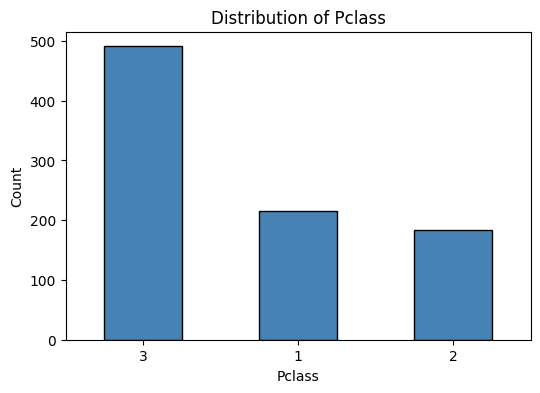

In [176]:
plot_categorical_column(titanic_df, 'Pclass')

Na powyższym wykresie widzimy, że większość psażerów podróżowała 3 klasą. Liczby pasażerów podróżujących 1 oraz 2 klasą są zbliżone - nie ma wartości odstających względem zmiennej Pclass.

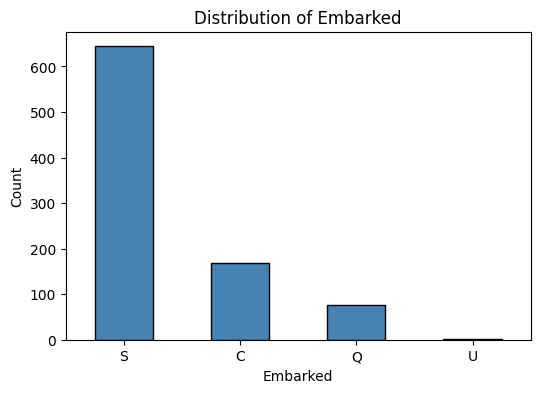

In [177]:
plot_categorical_column(titanic_df, 'Embarked')

Widzimy na wykresie, że większość pasażerów wsiadła w porcie S. Spora liczba pasażerów wsiadła w portach C oraz Q. Natomiast U (nieznanyc port startowy) to wartośc odstająca.

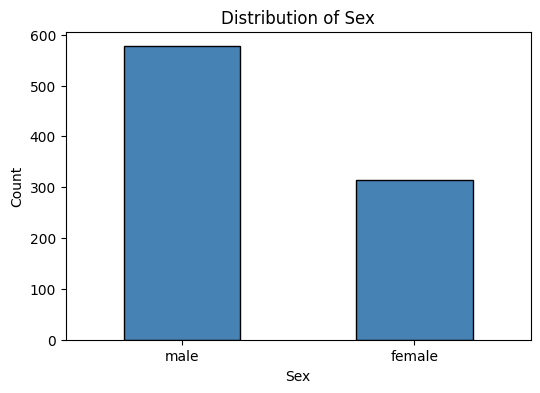

In [178]:
plot_categorical_column(titanic_df, 'Sex')

Widzimy na wykresie, ze na statku znajdowało się nieco więcej mężczyzn niż kobiet.

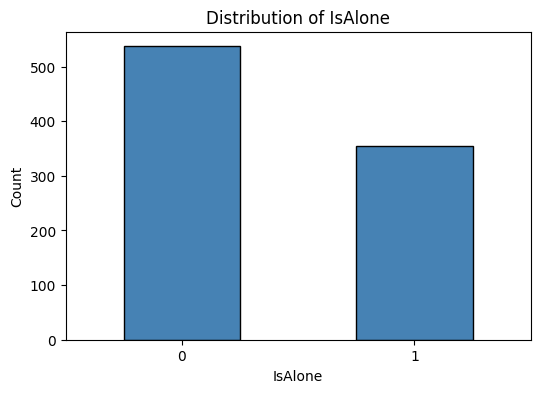

In [179]:
plot_categorical_column(titanic_df, 'IsAlone')

Widzimy na wykresach, że nieznacznie więcej pasażerów wybrało się samemu (bez krewnych).

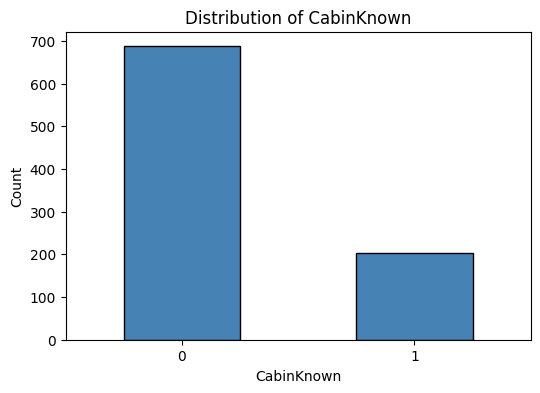

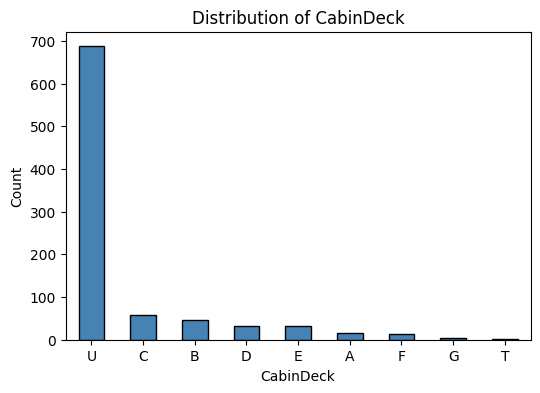

In [180]:
plot_categorical_column(titanic_df, 'CabinKnown')
plot_categorical_column(titanic_df, 'CabinDeck')

Widzimy na wykresach, że większość pasażerów nie ma przypisanej kabiny.

# Wizualizacja rozkładów cech



Pclass, Sex,  Embraked, Isalone, CabinDeck, CabinKnown,


Age (ew.grupy wiekowe),  (ew. SibSp, Parch), Fare,

In [181]:
def plot_categorical_distribution(df, col, target=None):
    plt.figure(figsize=(10,5))
    if target:
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f"Rozkład kategorii {col} względem {target}")
    else:
        sns.countplot(data=df, x=col)
        plt.title(f"Rozkład kategorii {col}")
    plt.show()

Rozkład Pclass względem survived

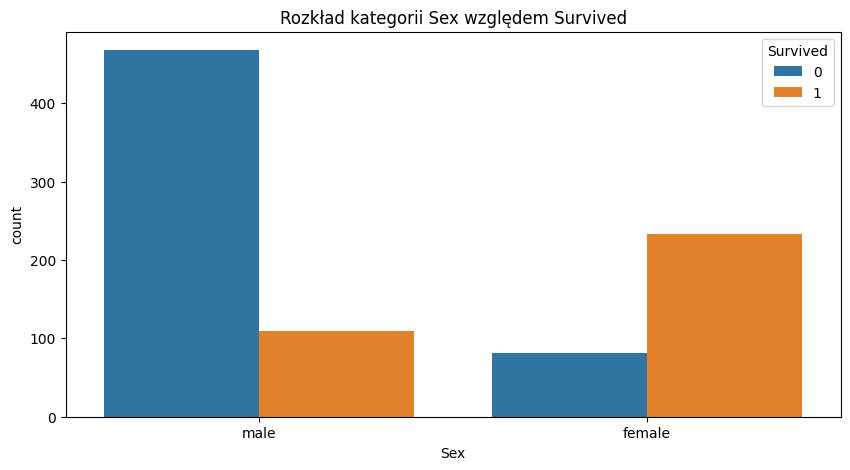

In [182]:
plot_categorical_distribution(titanic_df, 'Sex', 'Survived')

Widzimy na powyższym wykresie, że wyższy wskażnik przetrwania obserwujemy u kobiet. Należy jendka uwzględnić fakt, że w zbiorze danych znajduje się więcej mężczyzn. Jednak pomimo większej liczbie mężczyzn na stastku i tak przetrwało więcej kobiet.

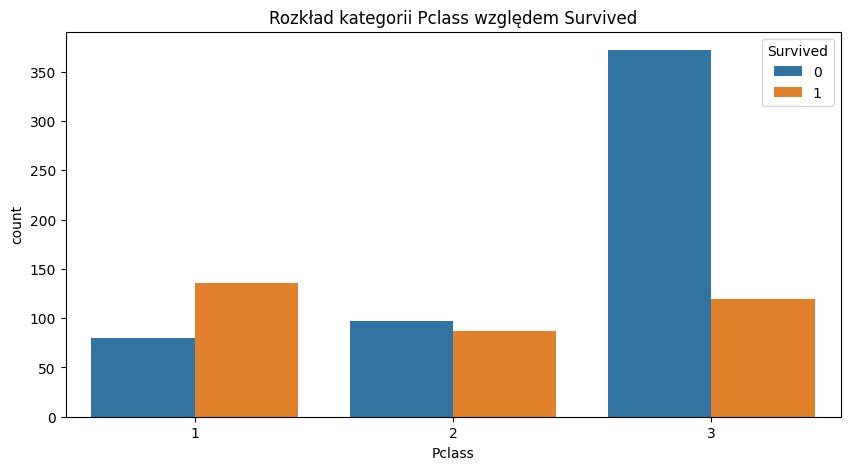

In [183]:
plot_categorical_distribution(titanic_df, 'Pclass', 'Survived')

Na powyższym wykresie widzimy, że najwięcej pasażerów przetrwało z klasy 1. Z kolei więcej liczbowo pasażerów podróżoujących 3 klasą przetrwało niż pasażerów z 2 klasy. Jednak należy uwzglednić, że klasa 3 jest liczniejsza - większy odsetek pasażerów spośród podróżujących daną klasą przetrwał z klasy 2.

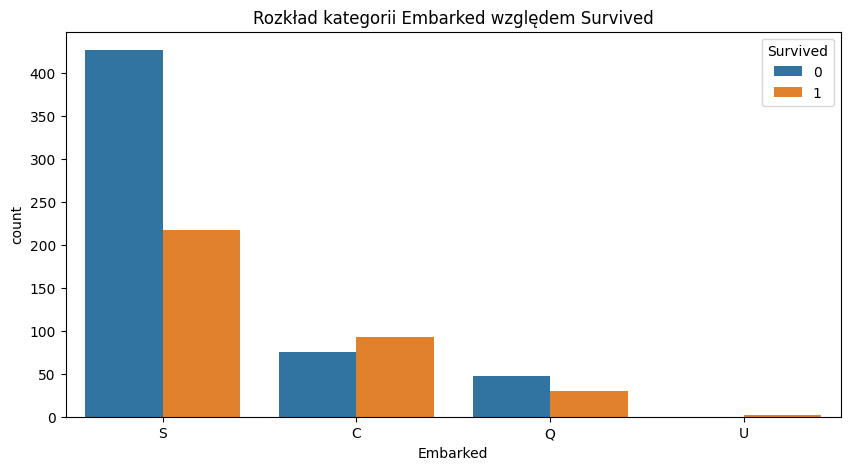

In [184]:
plot_categorical_distribution(titanic_df, 'Embarked', 'Survived')

Najięcej pasażerów wsiadło w porcie S, oraz najwięcej liczbowo pasażerów przetrwało tych którzy wsiedli w porcie S. Jednak odsetek pasażerów, którzy przetrwali jest większy dla portu C. Pasażerowie, dla których port startowy jest nieznany nie mają wpływu na analize danych (jest ich poniżej 1%).

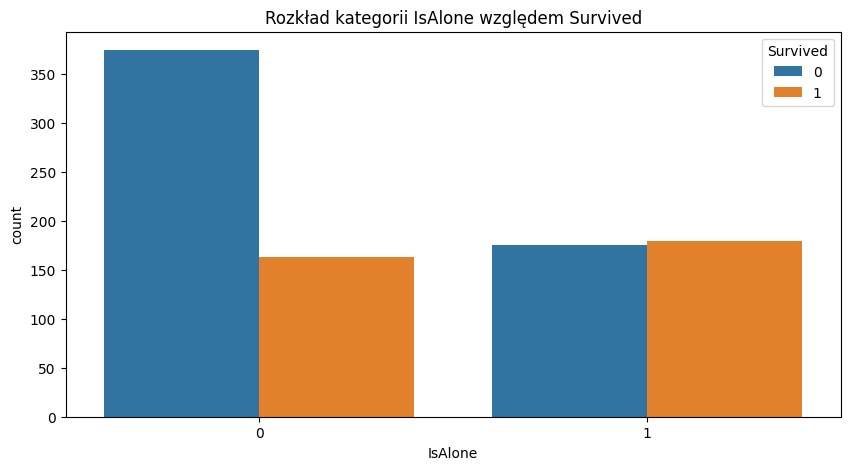

In [185]:
plot_categorical_distribution(titanic_df, 'IsAlone', 'Survived')

Widzimy na wykresie, że większość pasażerów wybrała się z co najmniej 1 krewnym. Z kolei pasażerowie, który  wybrali się bez krewnych mieli większy odsetek przeżycia.

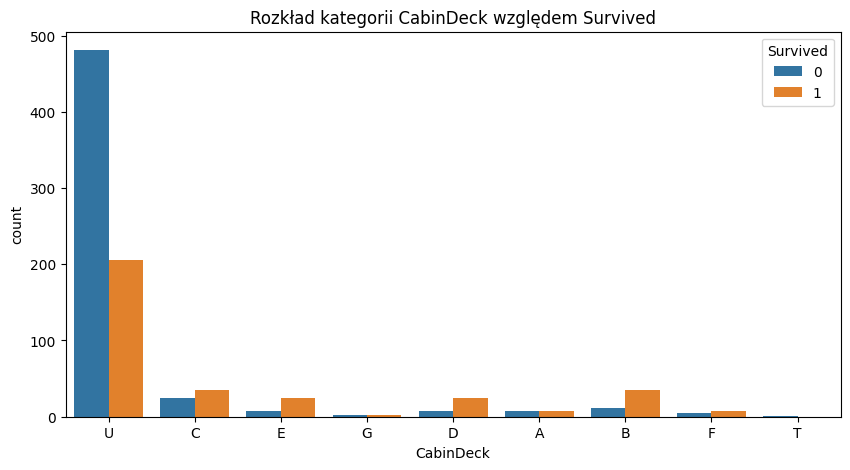

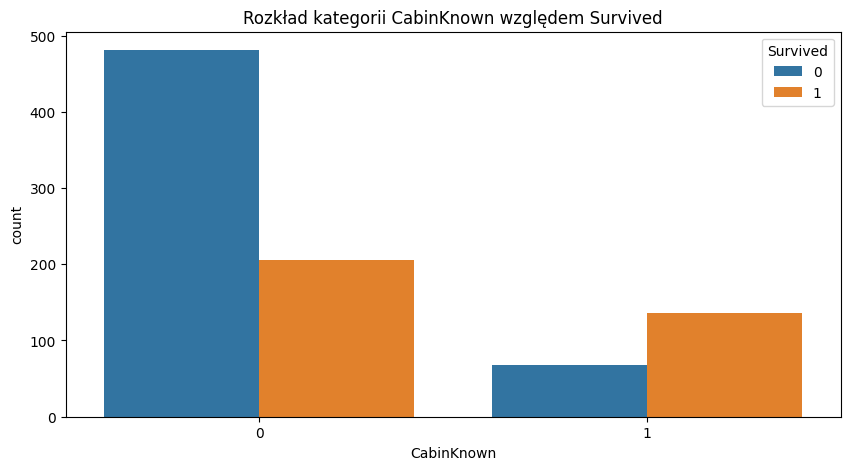

In [186]:
plot_categorical_distribution(titanic_df, 'CabinDeck', 'Survived')
plot_categorical_distribution(titanic_df, 'CabinKnown', 'Survived')

Widzimy na wykresie, że większość pasażerów nie miało przypisej kabiny oraz pokładu. Zauważmy, również że osoby przypisany do kabiny miały większą szansę na przeżycie.

In [187]:
def plot_numeric_distribution(df, col, target=None):
    plt.figure(figsize=(10,5))
    if target:
        sns.kdeplot(data=df, x=col, hue=target, common_norm=False)
        plt.title(f"Rozkład {col} względem {target}")
    else:
        sns.histplot(df[col], kde=True)
        plt.title(f"Histogram {col}")
    plt.show()

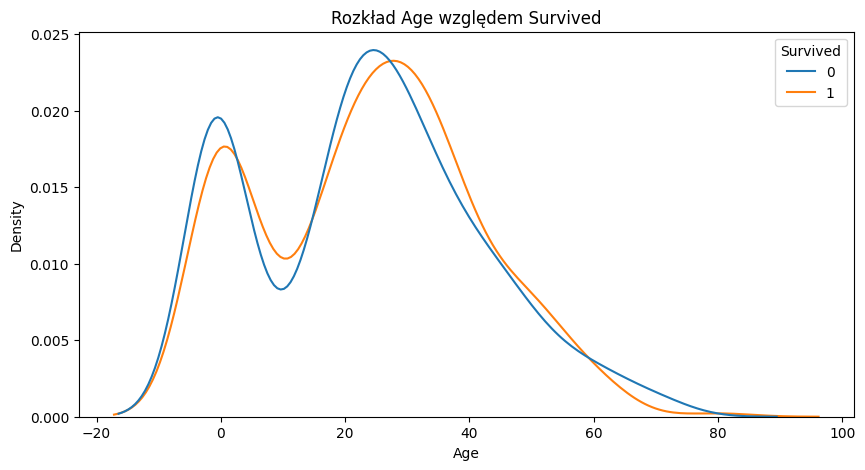

In [188]:
plot_numeric_distribution(titanic_df, 'Age', target='Survived')

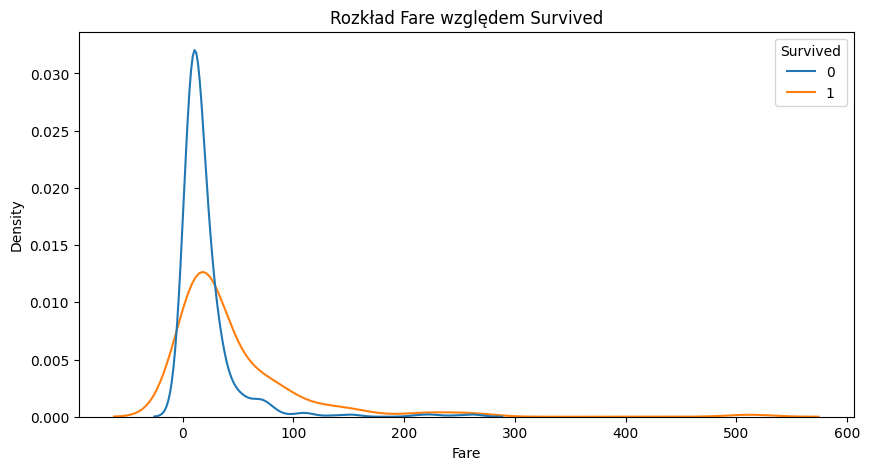

In [189]:
plot_numeric_distribution(titanic_df, 'Fare', target='Survived')

Na poniższym wykresie obserwujemy, że osoby który kupiły najtańsze z dostępnych biletów (prawodpodobnie bilety 3 klassy) mniały najmniejszą szansę na przeżycie. Z kolei grupy osób, które kupiły droższe bilety cechuje się wyższym odstekiem przetrwania.

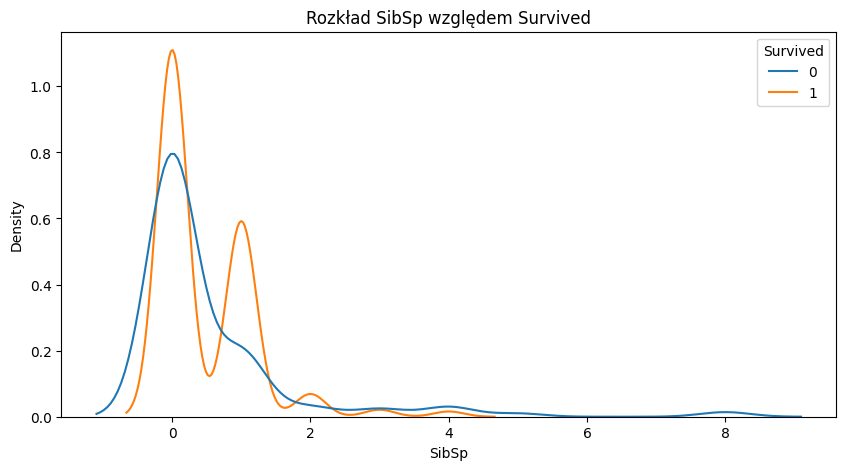

In [190]:
plot_numeric_distribution(titanic_df, 'SibSp', target='Survived')

Widzimy na wykresie, że największym odstekiem osób które przeżyły cechują sie grupy które wybrały się bez rodzeństwa/małżonka/ki lub 1 krewnym. Jendak należy uwzględnić fakt, że większość osób wybrała się bez rodzeństwa/małżonka/ki, co może zaburzać obserwcję.

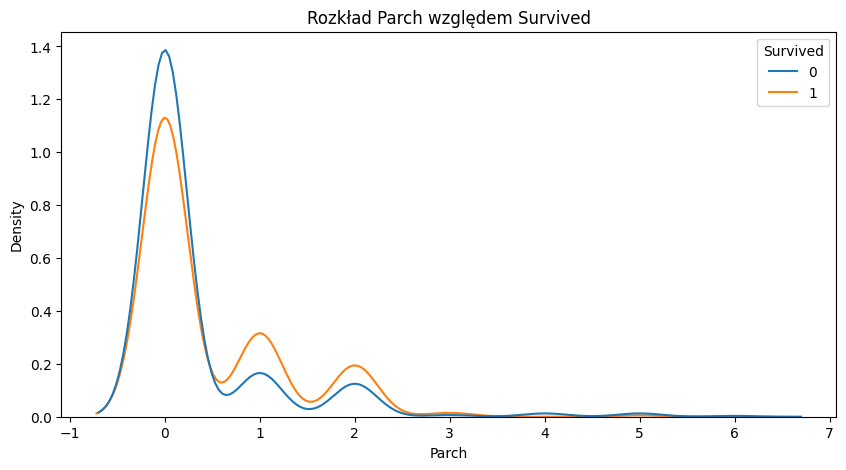

In [191]:
plot_numeric_distribution(titanic_df, 'Parch', target='Survived')

Widzimy na wykresie, że pasażerowie którzy wybrali się bez rodziców oraz dzieci mieli mniejsze szanse na przeżycie. Z kolei w pozostałych grupach obserwujemy nieznacznie większy odsetek osób, który przeżyły. Jendak należy uwzględnić fakt, że większość osób wybrała się bez rodziców oraz dzieci, co może zaburzac obserwację.



# Kodowanie Kolumn
Embarked oraz CabinDeck - one-hot encoding

Survived - binary encoding

PClass, Sex, IsAlone, CabinKnown - ordinal encoding

In [192]:
sex_mapping = {
    'male': 0,
    'female': 1
}

titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)



one_hot_encoded_titanic= pd.get_dummies(data=titanic_df, prefix='CabinDeck', columns=['CabinDeck'], dtype=np.int32) # pass in dataframe and columns to one-hot code
one_hot_encoded_titanic = pd.get_dummies(data=one_hot_encoded_titanic, prefix='Embarked', columns=['Embarked'], dtype=np.int32)
one_hot_encoded_titanic.head(n=1)

print(one_hot_encoded_titanic.head)

<bound method NDFrame.head of              Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    0  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0   
3                                       Heikkinen, Miss. Laina    1  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0   
5                                     Allen, Mr. William Henry    0  35.0   
.

In [193]:
count_unknown_embarked = titanic_df[titanic_df['Embarked'] == 'U'].shape[0]
print(f"Liczba rekordów z nieznanym portem zaokrętowania ('U'): {count_unknown_embarked}")

Liczba rekordów z nieznanym portem zaokrętowania ('U'): 2


In [194]:
def plot_correlation_matrix(df):
    """
    Plots a heatmap showing the correlation matrix for numeric columns in the DataFrame.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing numeric data.
    Returns:
        None. Displays the correlation heatmap.
    """
    # compute correlation matrix only for numeric columns
    corr = df.corr(numeric_only=True)

    # fmt=".2f" rounds the number to 0.01
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

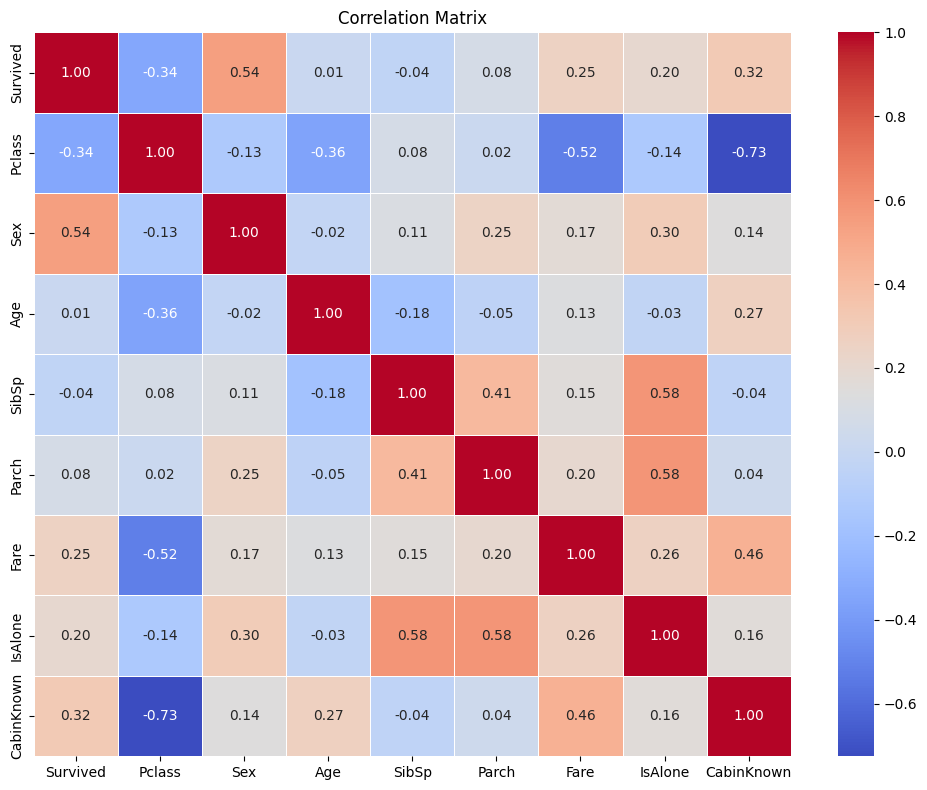

In [195]:
plot_correlation_matrix(titanic_df)

Widzimy na powyższym wykresie że wraz ze wzostem ceny biletu szanse na przeżycie wzrasta liniowo. Na szansę przeżycia wpływają rówmież płeć pasażera, klasa podróży, fakt czy pasażer miał przypisaną kabinę oraz czy wybrał się wraz z krewnymi.